In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
import re

In [2]:
train = pd.read_csv('../input_data/rank_train.csv')
test = pd.read_csv('../input_data/rank_test.csv')

player = pd.read_csv('../input_data/player_prefecture.csv', header=None)
fifa_2014_mem = pd.read_csv('../input_data/fifa2014mem.csv')

In [3]:
# 無観客試合のyを中央値をで補完
train.iloc[377, 1] = train['y'].median()

In [4]:
# 各スタジアムのcapaに対する動員比率
pre_y_capa = pd.DataFrame(train.groupby('stadium').sum()['y'] / train.groupby('stadium').sum()['capa'])
y_capa_df = pd.DataFrame({'stadium':np.array(pre_y_capa.index), 'y_capa':np.array(pre_y_capa[0])})

train = pd.merge(train, y_capa_df, how = 'left', on = 'stadium')
test = pd.merge(test, y_capa_df, how = 'left', on = 'stadium')

In [5]:
train_x = train.copy().drop(['y', 'id'], axis=1)
train_y = train['y']
test_x = test.drop(['id'], axis=1)

In [6]:
all_x = pd.concat([train_x, test_x])
all_x

,year,stage,match,gameday,time,home,away,stadium,tv,home_score,...,away_08,away_09,away_10,away_11,name,address,capa,team,rank,y_capa
0,2012,Ｊ１,第１節第１日,03/10(土),14:04,ベガルタ仙台,鹿島アントラーズ,ユアテックスタジアム仙台,スカパー／ｅ２／スカパー光／ＮＨＫ総合,1,...,小笠原 満男,本山 雅志,大迫 勇也,ジュニーニョ,ユアテックスタジアム仙台,宮城県仙台市泉区七北田字柳78,19694,ベガルタ仙台,1,0.777358
1,2012,Ｊ１,第３節第１日,03/24(土),13:03,ベガルタ仙台,大宮アルディージャ,ユアテックスタジアム仙台,スカパー／ｅ２／スカパー光（Ｊ ＳＰＯＲＴＳ １）,4,...,渡邉 大剛,曺 永哲,東 慶悟,ラファエル,ユアテックスタジアム仙台,宮城県仙台市泉区七北田字柳78,19694,ベガルタ仙台,1,0.777358
2,2012,Ｊ１,第５節第１日,04/07(土),14:03,ベガルタ仙台,ジュビロ磐田,ユアテックスタジアム仙台,スカパー／ｅ２／スカパー光／ＮＨＫ仙台／ＮＨＫ静岡,2,...,山田 大記,松浦 拓弥,菅沼 実,前田 遼一,ユアテックスタジアム仙台,宮城県仙台市泉区七北田字柳78,19694,ベガルタ仙台,1,0.777358
3,2012,Ｊ１,第７節第１日,04/21(土),19:04,ベガルタ仙台,ＦＣ東京,ユアテックスタジアム仙台,スカパー／ｅ２／スカパー光／ＮＨＫ ＢＳ１,4,...,石川 直宏,大竹 洋平,羽生 直剛,渡邉 千真,ユアテックスタジアム仙台,宮城県仙台市泉区七北田字柳78,19694,ベガルタ仙台,1,0.777358
4,2012,Ｊ１,第１０節第１日,05/06(日),13:04,ベガルタ仙台,清水エスパルス,ユアテックスタジアム仙台,スカパー／ｅ２／スカパー光／ＮＨＫ仙台,0,...,河井 陽介,ジミー フランサ,大前 元紀,高木 俊幸,ユアテックスタジアム仙台,宮城県仙台市泉区七北田字柳78,19694,ベガルタ仙台,1,0.777358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,2014,Ｊ２,第４２節第１日,11/23(日・祝),14:04,ザスパクサツ群馬,愛媛ＦＣ,正田醤油スタジアム群馬,スカパー！／スカパー！プレミアムサービス,3,...,吉村 圭司,原川 力,堀米 勇輝,河原 和寿,正田醤油スタジアム群馬,群馬県前橋市敷島町66,15135,ザスパクサツ群馬,15,0.228665
309,2014,Ｊ２,第３５節第１日,10/04(土),13:03,Ｖ・ファーレン長崎,ファジアーノ岡山,長崎市総合運動公園かきどまり陸上競技場,スカパー！／スカパー！プレミアムサービス,1,...,三村 真,片山 瑛一,久保 裕一,ウーゴ,長崎市総合運動公園かきどまり陸上競技場,長崎県長崎市柿泊町2210,16000,Ｖ・ファーレン長崎,13,0.246250
310,2014,Ｊ２,第３８節第１日,10/26(日),14:03,Ｖ・ファーレン長崎,ロアッソ熊本,長崎市総合運動公園かきどまり陸上競技場,スカパー！／スカパー！プレミアムサービス,0,...,髙柳 一誠,嶋田 慎太郎,澤田 崇,齊藤 和樹,長崎市総合運動公園かきどまり陸上競技場,長崎県長崎市柿泊町2210,16000,Ｖ・ファーレン長崎,10,0.246250
311,2014,Ｊ２,第３６節第１日,10/11(土),13:03,コンサドーレ札幌,ジェフユナイテッド千葉,札幌厚別公園競技場,スカパー！／スカパー！プレミアムサービス,0,...,幸野 志有人,町田 也真人,谷澤 達也,森本 貴幸,札幌厚別公園競技場,北海道札幌市厚別区上野幌3条1-2-1,19620,コンサドーレ札幌,8,0.368511


In [7]:
# rank関数
def rank(base_col, col_name, rank_arr):
    rank = 0
    all_x[col_name] = 0
    for i in rank_arr:
        all_x.loc[all_x[base_col]==i, col_name] = rank
        rank += 1
    return all_x

In [8]:
# 試合会場の都道府県の25歳以上の100人当たりのサッカー人口
address_col_num = all_x.columns.get_loc('address')
all_x['player_pref'] = 0
for i in range(len(player)):
    for j in range(len(all_x)):
        if player.iloc[i, 1] in all_x.iloc[j, address_col_num]:
            all_x.iloc[j, -1] = player.iloc[i, 3]
            
home_0_col_num = all_x.columns.get_loc('home_01')
away_11_col_num = all_x.columns.get_loc('away_11')

# 各試合のFIFA2014日本代表選手の出場選手人数
all_x['fifa_men_sum'] = 0
for i in range(len(fifa_2014_mem)):
    for mem in range(home_0_col_num, away_11_col_num + 1):
        for j in range(len(all_x)):
            if fifa_2014_mem.iloc[i, 0] == all_x.iloc[j, mem]:
                all_x.iloc[j, -1] += 1

In [9]:
all_x['week'] = all_x['gameday'].str[-2].replace(('月','火','水','木','金'), '平日')
all_x['iweek'] = 0
all_x.loc[all_x['week']=='土', 'iweek'] = 3
all_x.loc[all_x['week']=='日', 'iweek'] = 1
all_x.loc[all_x['week']=='祝', 'iweek'] = 2

all_x['match_day'] =all_x['match'].str.split('第', expand = True)[2].str.split('日',expand=True)[0].astype('int')
all_x['match'] =all_x['match'].str.split('第', expand = True)[1].str.split('節',expand=True)[0].astype('int')


all_x['gameday'] = all_x['gameday'].str.split('/', expand = True)[0].astype('int')

all_x['h_time'] = all_x['time'].str.split(':', expand = True)[0].astype('int')
all_x['m_time'] = all_x['time'].str.split(':', expand = True)[1].astype('int')

all_x['t_time'] = all_x.apply(lambda x: x['h_time'] * 60 + x['m_time'], axis=1)
all_x['pre_rank_t_time'] = np.floor(all_x['t_time'] /50) * 50
all_x['t_time'] = all_x['t_time'].max() - np.clip(all_x['t_time'], 782, 1144)
t_time_rank_arr = [1200.0, 750.0, 1050.0, 1150.0, 950.0, 1100.0, 1000.0, 800.0, 900.0, 850.0]
all_x = rank(base_col='pre_rank_t_time', col_name='t_time_rank', rank_arr=t_time_rank_arr)

# rank関数を用いた特徴量
time_rank_arr = [20, 12, 17, 15, 18, 13, 16, 14, 19]
all_x = rank(base_col='h_time', col_name='h_time_rank', rank_arr=time_rank_arr)

gameday_rank_arr = [12, 6, 10, 11, 9, 8, 7, 4, 3, 5]
all_x = rank(base_col='gameday', col_name='gameday_rank',  rank_arr=gameday_rank_arr)

pref_rank_arr =[2.38, 2.58, 2.68, 2.87, 1.68, 2.11, 2.13, 2.79,  2.0, 2.24, 2.91,
              2.82, 2.94,  3.4, 3.29, 2.52, 2.55, 2.67, 3.55, 3.91, 2.73, 3.26,
               4.5, 3.32, 4.35, 2.99, 2.09, 3.96, 3.68, 5.01]
all_x = rank(base_col='player_pref', col_name='pref_rank',  rank_arr=pref_rank_arr)

match_day_rank_arr = [4, 3, 1, 2]
all_x = rank(base_col='match_day', col_name='match_day_rank',  rank_arr=match_day_rank_arr)

y_capa_y_mean = train.groupby('y_capa')['y'].mean()
all_x = rank(base_col='y_capa', col_name='y_capa_rank',  rank_arr=y_capa_y_mean.sort_values().index)

referee_y_mean = train.groupby('referee')['y'].mean()
all_x = rank(base_col='referee', col_name='referee_rank',  rank_arr=referee_y_mean.sort_values().index)

all_x['rank'] = all_x['rank'].max() - all_x['rank']

# tvに関する特徴量
all_x['nhk_sogo'] = all_x.apply(lambda x: 1 if '総合' in x['tv'] else 0, axis=1)
all_x['tv_num'] = all_x.apply(lambda x: len(x['tv'].split('／')), axis=1)
all_x['record'] = all_x.apply(lambda x: 0 if '録' in x['tv'] else 1, axis=1)
all_x['j2_rain'] = all_x.apply(lambda x: 1 if (x['stage'] == 'Ｊ２') and ('雨' == x['weather']) else 0, axis=1)

all_x['j2_capa'] = all_x.apply(lambda x: x['capa'] * 0.8 if x['stage'] == 'Ｊ２' else x['capa'], axis=1)

all_x['t&f'] = all_x.apply(lambda x: 1 if '陸上競技場' in x['stadium'] else 0, axis=1)

all_x['temperature'] = np.floor(all_x['temperature'])
all_x['temperature'] = all_x.apply(lambda x:all_x['temperature'].max() - x['temperature'] if all_x['temperature'].median() < x['temperature'] else x['temperature'], axis=1)

In [10]:
all_x = all_x[[
    'capa',
    'rank',
    'stage',
    'weather',
    'stadium',
    'week', 
    'home',
    'away',
    'fifa_men_sum',
    'iweek',
    't_time',
    'pre_rank_t_time',
    't_time_rank',
    'h_time_rank',
    'gameday_rank',
    'pref_rank',
    'match_day_rank',
    'nhk_sogo',
    'tv_num',
    'record',
    'temperature',
    'match',
    't&f',
    'j2_rain',
    'referee_rank',
    'y_capa',
]]

In [11]:
all_x = pd.get_dummies(all_x, drop_first=True)
all_x

,capa,rank,fifa_men_sum,iweek,t_time,pre_rank_t_time,t_time_rank,h_time_rank,gameday_rank,pref_rank,...,away_横浜ＦＣ,away_水戸ホーリーホック,away_浦和レッズ,away_清水エスパルス,away_湘南ベルマーレ,away_鹿島アントラーズ,away_ＦＣ岐阜,away_ＦＣ東京,away_ＦＣ町田ゼルビア,away_Ｖ・ファーレン長崎
0,19694,21,0,3,360,800.0,7,7,8,23,...,0,0,0,0,0,1,0,0,0,0
1,19694,21,0,3,421,750.0,1,5,8,23,...,0,0,0,0,0,0,0,0,0,0
2,19694,21,0,3,361,800.0,7,7,7,23,...,0,0,0,0,0,0,0,0,0,0
3,19694,21,2,3,60,1100.0,5,8,7,23,...,0,0,0,0,0,0,0,1,0,0
4,19694,21,0,1,420,750.0,1,5,9,23,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,15135,7,0,2,360,800.0,7,7,3,3,...,0,0,0,0,0,0,0,0,0,0
309,16000,9,0,3,421,750.0,1,5,2,4,...,0,0,0,0,0,0,0,0,0,0
310,16000,12,0,1,361,800.0,7,7,2,4,...,0,0,0,0,0,0,0,0,0,0
311,19620,14,0,3,421,750.0,1,5,2,16,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# データの再分割
train_x = all_x.iloc[:train_x.shape[0], :].reset_index(drop=True)
test_x = all_x.iloc[train_x.shape[0]:, :].reset_index(drop=True)

In [13]:
train_x

,capa,rank,fifa_men_sum,iweek,t_time,pre_rank_t_time,t_time_rank,h_time_rank,gameday_rank,pref_rank,...,away_横浜ＦＣ,away_水戸ホーリーホック,away_浦和レッズ,away_清水エスパルス,away_湘南ベルマーレ,away_鹿島アントラーズ,away_ＦＣ岐阜,away_ＦＣ東京,away_ＦＣ町田ゼルビア,away_Ｖ・ファーレン長崎
0,19694,21,0,3,360,800.0,7,7,8,23,...,0,0,0,0,0,1,0,0,0,0
1,19694,21,0,3,421,750.0,1,5,8,23,...,0,0,0,0,0,0,0,0,0,0
2,19694,21,0,3,361,800.0,7,7,7,23,...,0,0,0,0,0,0,0,0,0,0
3,19694,21,2,3,60,1100.0,5,8,7,23,...,0,0,0,0,0,0,0,1,0,0
4,19694,21,0,1,420,750.0,1,5,9,23,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1948,22338,1,0,3,121,1050.0,2,4,1,20,...,0,1,0,0,0,0,0,0,0,0
1949,22338,1,0,3,121,1050.0,2,4,6,20,...,0,0,0,0,0,0,1,0,0,0
1950,22338,1,0,2,420,750.0,1,5,7,20,...,1,0,0,0,0,0,0,0,0,0
1951,22338,1,0,3,121,1050.0,2,4,1,20,...,0,0,0,0,0,0,0,0,0,0


In [14]:
params = {
    'eta':0.1,
    'max_depth':5,
    'colsample_bytree':1.0,
    'subsample':0.9,
    'lambda':1,
    'alpha':0,
    'min_child_weight':3,
    'random_state':0
}

model = xgb.XGBRegressor(**params)

In [15]:
# ホールドアウト
train_val_x, valid_x, train_val_y, valid_y = train_test_split(train_x,train_y ,test_size=0.2,shuffle=False)

model.fit(train_val_x, train_val_y)
valid_pred = model.predict(valid_x)
valid_pred = np.floor(valid_pred)
print(np.sqrt(mean_squared_error(valid_y, valid_pred)))

2015.5072527613252


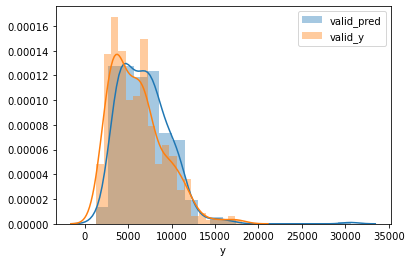

In [16]:
sns.distplot(
    valid_pred,    # データ
    kde = True,      # 近似密度関数の表示有無
    bins = 20,      # 変数の刻み数
    label = 'valid_pred'
) 

sns.distplot(
    valid_y,    # データ
    kde = True,      # 近似密度関数の表示有無
    bins = 20,       # 変数の刻み数
    label = 'valid_y'
) 

plt.legend()
plt.show()

残差確認

In [17]:
model.fit(train_x, train_y)

XGBRegressor(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, eta=0.1, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             lambda=1, learning_rate=0.100000001, max_delta_step=0, max_depth=5,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [18]:
pred = model.predict(test_x)
pred = np.floor(pred)

In [19]:
# データをcsv形式に加工。
out = pd.DataFrame({'id':test['id'], 'y':pred})

# idでソート。
out_sorted = out.sort_values('id')

In [20]:
out_sorted.to_csv('../submit/yoshioka_xgboost_regression.csv', sep=',', header=False, index=False)

In [21]:
out_sorted.describe()

,id,y
count,313.000000,313.000000
mean,16142.252396,11893.415039
std,224.441223,7903.622559
min,15822.000000,2961.000000
25%,15907.000000,5905.000000
50%,16261.000000,9852.000000
75%,16346.000000,15195.000000
max,16436.000000,52702.000000


In [22]:
pd.read_csv('../submit/yoshioka_xgboost_regression.csv')

,15822,14043.0
0,15823,18123.0
1,15824,36938.0
2,15825,13652.0
3,15827,26652.0
4,15828,15188.0
...,...,...
307,16432,7452.0
308,16433,12635.0
309,16434,7362.0
310,16435,8188.0
